In [1]:
import ast
import sys
import tempfile
import os
sys.path.append('/home/a/a270229/.conda/envs/mypython/lib/python3.10/site-packages')
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
# import cdo
from cdo import *


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import regionmask
import xarray as xr
import cf_xarray
from scipy.interpolate import interp2d
from scipy.interpolate import griddata


#### Fuction to plot the temperature circle

In [112]:
def plot_temperature_cirle(data,year='2017',cmap=None,vMin=-3,vMax=3,optnm=None):
    """
    Description:
    The function generates a temperature circle plot based on the provided data, displaying temperature anomalies across different continents and countries. 
    The temperature anomalies are represented using colors from the specified colormap. 
    The function incorporates various visual elements such as text labels, lines, and annotations to create an informative visualization of temperature data.

    Arguments:
    data (dictonary): A dictionary containing temperature data grouped by continents and countries.
                      Use function categorize_countries_by_continents to generate values.
    year: str, The year being plotted (default is 2017).
    cmap: str, A colormap for representing the temperature values (default is None).
    vMin: float, Minimum value for normalization of the colormap (default is -3).
    vMax: float, Maximum value for normalization of the colormap (default is 3).
    optnm: str, Optional name for the output file. If provided, the plot is saved with this name; 
           otherwise, the plot is displayed but not saved.
   
    Returns:
    The function returns a matplotlib plot object, which can be used to display the plot or save it to a file.
    """
    
    # Font and background
    backgroundcolor =  '#ffffff' #'#faf2eb'
    fontname = None #'Lato'
    yearname = year # ploting year

    # Fuction to define the circular plot
    def rotText(areaText, defaultspacing, rotangleoffset, rText, fontname):
        angle = areaText[0][1]
        for ii, l in enumerate(areaText):
            if ii > 0:
                angle += defaultspacing + l[1]
            plt.text(
                (rText) * np.sin(np.deg2rad(angle)),
                (rText) * np.cos(np.deg2rad(angle)),
                '{}'.format(l[0]),
                {'ha': 'center', 'va': 'center'},
                rotation=-angle + rotangleoffset,
                fontsize=15,
                fontname=fontname,
            )


    plt.rcParams['axes.facecolor'] = backgroundcolor
    mpl.rcParams.update({'font.size': 22})

    cmap = plt.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=vMin, vmax=vMax)

    Ncountries = 0
    Ncontinents = 0
    for countrylist in data.items():
        Ncountries += len(countrylist[1])
        Ncontinents += 1

    spaceBetweenContinents = 10.0  # 3.0 degrees
    Nspaces = Ncontinents - 1
    anglePerCountry = (345.0 - Nspaces * spaceBetweenContinents) / (Ncountries - 1)


    fig, ax = plt.subplots(figsize=(15, 15))
    renderer = fig.canvas.get_renderer()
    transf = ax.transData.inverted()

    # Adjust to add aditional levels
    # Adjustments to be made across the script if values below are changed 
    limitangles = np.linspace(np.deg2rad(5.0), np.deg2rad(355.0), 500)
    scaleRs = [
        # [1.0, '-5.0', True, 0.25],
        # [1.5, '-5.0', True, 0.25],
        [2.02, '-3.0', True, 0.25],
        [2.4, '-2.0', True, 0.25],
        [2.77, '-1.0', True, 0.25],
        [3.15, '0.0', True, 1.00],
        [3.53, '+1.0', True, 0.25],
        [3.9, '+2.0', True, 0.25],
        [4.27, '+3.0', True, 0.25],
        # [5.0, '+3.0', True, 0.25],
        # [5.5, '+5.0', True, 0.25],
        # [6.0, '+5.0', True, 0.25],
        # [2.0, '$^\\circ$C', False, 0.0]
    ]

    for r in scaleRs:
        if r[2]:
            ax.plot(r[0] * np.sin(limitangles), r[0] * np.cos(limitangles), linewidth=r[3], color='#888888', linestyle='-')
        plt.text(
            0.0,
            r[0],
            '{}'.format(r[1]),
            {'ha': 'center', 'va': 'center'},
            fontsize=12,
            fontname=fontname,
        )


    angle = 7.5
    rText = 5.0  #Plots the country names
    for continent in ['AFRICA', 'ASIA', 'EUROPE', 'AMERICA', 'OCEANIA']:
        for country in data[continent]:

            if angle < 185.0:
                rotangle = -angle + 90.0
            else:
                rotangle = -angle - 90.0

            plt.text(
                (rText) * np.sin(np.deg2rad(angle)),
                (rText) * np.cos(np.deg2rad(angle)),
                '{}'.format(country[0]),
                {'ha': 'center', 'va': 'center'},
                rotation=rotangle,
                fontsize=8,
                fontname=fontname,
                bbox={
                    'facecolor': backgroundcolor,
                    'linestyle': 'solid',
                    'linewidth': 0.0,
                    'boxstyle': 'square,pad=0.0'
                }
            )

            # plot the -- lines
            ax.plot(
                [1.6 * np.sin(np.deg2rad(angle)), 5.0 * np.sin(np.deg2rad(angle))],
                [1.6 * np.cos(np.deg2rad(angle)), 5.0 * np.cos(np.deg2rad(angle))],
                linewidth=0.6,
                linestyle='--',
                color='#DEDEDE'
            )

            lowerRoffset = 0.015
            temperatureAnomaly = country[1]

            # plot bars
            rValue = 2.0 + (temperatureAnomaly + 3.0) / 4.0 * 1.5  # a lot more clever way for computing the radius should be used here...
            ax.plot(
                [(1.6 + lowerRoffset) * np.sin(np.deg2rad(angle)), rValue * np.sin(np.deg2rad(angle))],
                [(1.6 + lowerRoffset) * np.cos(np.deg2rad(angle)), rValue * np.cos(np.deg2rad(angle))],
                linewidth=4.3,
                linestyle='-',
                color='#202020'
            )
            ax.plot(
                [(1.6 + lowerRoffset) * np.sin(np.deg2rad(angle)), rValue * np.sin(np.deg2rad(angle))],
                [(1.6 + lowerRoffset) * np.cos(np.deg2rad(angle)), rValue * np.cos(np.deg2rad(angle))],
                linewidth=4.0,
                linestyle='-',
                color=cmap(norm(temperatureAnomaly))
            )

            angle += anglePerCountry
        angle += spaceBetweenContinents



    c = Circle((0.0, 0.0), radius=1.3, fill=True, color='#fff9f5')
    ax.add_patch(c)
    plt.text(
        0.0,
        -0.52,
        yearname,
        {'ha': 'center', 'va': 'bottom'},
        fontsize=40,
        fontname=fontname,
    )
    plt.text(
        0.0,
        0.27,
        'Time',
        {'ha': 'center', 'va': 'center'},
        fontsize=26,
        fontname=fontname,
    )

    angles = np.linspace(np.deg2rad(0.0), np.deg2rad(360.0), 1000)
    rs = [1.3, 1.6] #name cirle
    for r in rs:
        ax.plot(r * np.sin(angles), r * np.cos(angles), linewidth=1.0, color='#666666', linestyle='-')

    #main title
    plt.title('Global Temperature Anomalies', fontsize=20, loc='center', pad=50)


    # name of continents
    areaText = [
        ['A', 30.0],
        ['f', 0.3],
        ['r', -0.05],
        ['i', -0.15],
        ['c', -0.15],
        ['a', 0.2],
    ]
    rText, defaultspacing, rotangleoffset = 1.43, 4.4, 0.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    areaText = [
        ['E', 210.0],
        ['u', 0.0],
        ['r', 0.3],
        ['o', 0.7],
        ['p', 0.0],
        ['e', 0.0],
    ]
    rText, defaultspacing, rotangleoffset = 1.455, -5.5, 180.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    areaText = [
        ['A', 130.0],
        ['s', -0.8],
        ['i', 0.0],
        ['a', 0.0],
    ]
    rText, defaultspacing, rotangleoffset = 1.455, -4.7, 180.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    areaText = [
        ['A', 260.0],
        ['m', 2.5],
        ['e', 0.6],
        ['r', -0.15],
        ['i', -2.0],
        ['c', -2.0],
        ['a', -0.15],
    ]
    rText, defaultspacing, rotangleoffset = 1.43, 5.85, 0.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    areaText = [
        ['O', 322.5],
        ['c', 1.0],
        ['e', 0.0],
        ['a', 0.2],
        ['n', 0.2],
        ['i', -0.3],
        ['a', -0.3],
    ]
    rText, defaultspacing, rotangleoffset = 1.425, 4.8, 0.0
    rotText(areaText, defaultspacing, rotangleoffset, rText, fontname)

    ax.set_xlim([-5.0, 5.0])
    ax.set_ylim([-5.0, 5.0])
    plt.axis('off')
        
    if optnm:
        plt.savefig(optnm, bbox_inches='tight', format='png',facecolor=backgroundcolor, edgecolor='none', dpi=160)

    # Return the plot
    return plt

#### Function to generate the temperature anomalie values

In [146]:
def categorize_countries_by_continents(tas, lon, lat, glbmn):
    """
    Categorizes countries based on their continents and calculates mean values of a given data array.

    Args:
    tas (array): Temperature data array.
    lon (array): Array of longitudes corresponding to the temperature data.
    lat (array): Array of latitudes corresponding to the temperature data.
    glbnm (array) : Global mean value

    Returns:
    str: A string containing the categorized countries by continents along with their mean values.
    """
    # Get the continent information for each country
    countries = regionmask.defined_regions.natural_earth_v4_1_0.countries_50
    countriesmask = countries.mask(lon, lat)

    # Create lists for each continent
    continent_countries = {
        'NAMER': [],  # North and South America
        'AS': [],  # Asia
        'EU': [],  # Europe
        'AF': [],  # Africa
        'OC': [],  # Oceania
        # 'AN': []   # Antarctica
    }

    # Full names of continents for printing
    continent_countries_full = {
        'NAMER': 'AMERICA',
        'AS': 'ASIA',
        'EU': 'EUROPE',
        'AF': 'AFRICA',
        'OC': 'OCEANIA',
        # 'AN': 'ANTARCTICA'
    }

    # Categorize countries by continents and calculate mean values
    for i, j in enumerate(countries.abbrevs):
        
        nm = countries.names[i]
        mask = countriesmask == i
        
        Dcn = tas.where(mask)
        Cmn = glbmn.where(mask)
        Can = (Dcn - Cmn)/Cmn
        mn = (Can.mean(dim=['lat','lon']))*100
        
        mn = mn.where(~((mn > 3) | (mn < -4)), 0.0)
        # mn = mn.where(~((mn > 0) | (mn < 0)), 0.0)

        # mn = ((Mn-glbmn)/glbmn)*10
        
        # Mn = tas.where(mask).mean(dim=['lat','lon'])
        # nm = countries.names[i]
        # 

        try:
            country_alpha_2 = country_name_to_country_alpha2(nm)
            if nm == 'Antarctica':
                continent_code = 'OC'  # Assign 'AN' directly if the country is Antarctica
            else:
                continent_code = country_alpha2_to_continent_code(country_alpha_2)
                if continent_code in ('NA', 'SA'):
                    continent_code = 'NAMER'  # Merge North and South America
            continent_name = continent_code
        except KeyError:
            continent_name = 'nan'

        # Append the country and mean value to the respective continent list
        if not np.isnan(mn.values.item()):
            if continent_code in continent_countries:
                continent_countries[continent_code].append([nm, mn.values.item()])

    # Return the list of countries arranged by continents
    result = "data={\n"
    for continent_code, countries_list in continent_countries.items():
        full = "'"+continent_countries_full[continent_code]+"'"
        result += f"{full}:\n[\n"
        for country in countries_list:
            result += f"\t{str(country)},\n"
        result += '\n],\n'
    result += "}"
    
    result = result.lstrip("data=")
    result_dict = ast.literal_eval(result)

    return result_dict

In [118]:
t2mfile = "/work/ab0995/a270229/work/test/tco1279_runs/data/t2.nc"
ds = xr.open_dataset(t2mfile)
tmp = ds['2t']
tas = tmp #.isel(time=slice(0, -1, 20), lon=slice(0, -1, 20), lat=slice(1, -1, 20), height=0)

In [119]:
# Example usage of the function
# lon = tas.lon  # Your longitude data
# lat = tas.lat  # Your latitude data
# dat = tas[0]  # Your 'tas' array data
# result = categorize_countries_by_continents(dat, lon, lat, 277.83237)
# # result = categorize_countries_by_continents(dat, lon, lat, 290.9608)

# result

In [120]:
# plot=plot_temperature_cirle(result,cmap='RdYlBu_r',vMin=-3,vMax=3,optnm='sam.png')
# plot.show()

In [121]:
LN=tmp.lon
LT=tmp.lat

In [139]:
t2mfile = "/work/bm1378/a270229/nudge_files/testruns/LUMI_runs/tco1279l137/test/2t.nc"
ds = xr.open_dataset(t2mfile)
tmp = ds['2t']
tas = tmp.isel(lon=slice(0, -1, 20), lat=slice(1, -1, 20))

In [140]:
climatology = tas.mean(dim='time')
# anomaly = ((tas - climatology)/climatology)*100

In [147]:
# anomaly[0].plot()
lon = tas.lon  # Your longitude data
lat = tas.lat  # Your latitude data
dat = tas[150]  # Your 'tas' array data
result = categorize_countries_by_continents(dat, lon, lat, climatology)

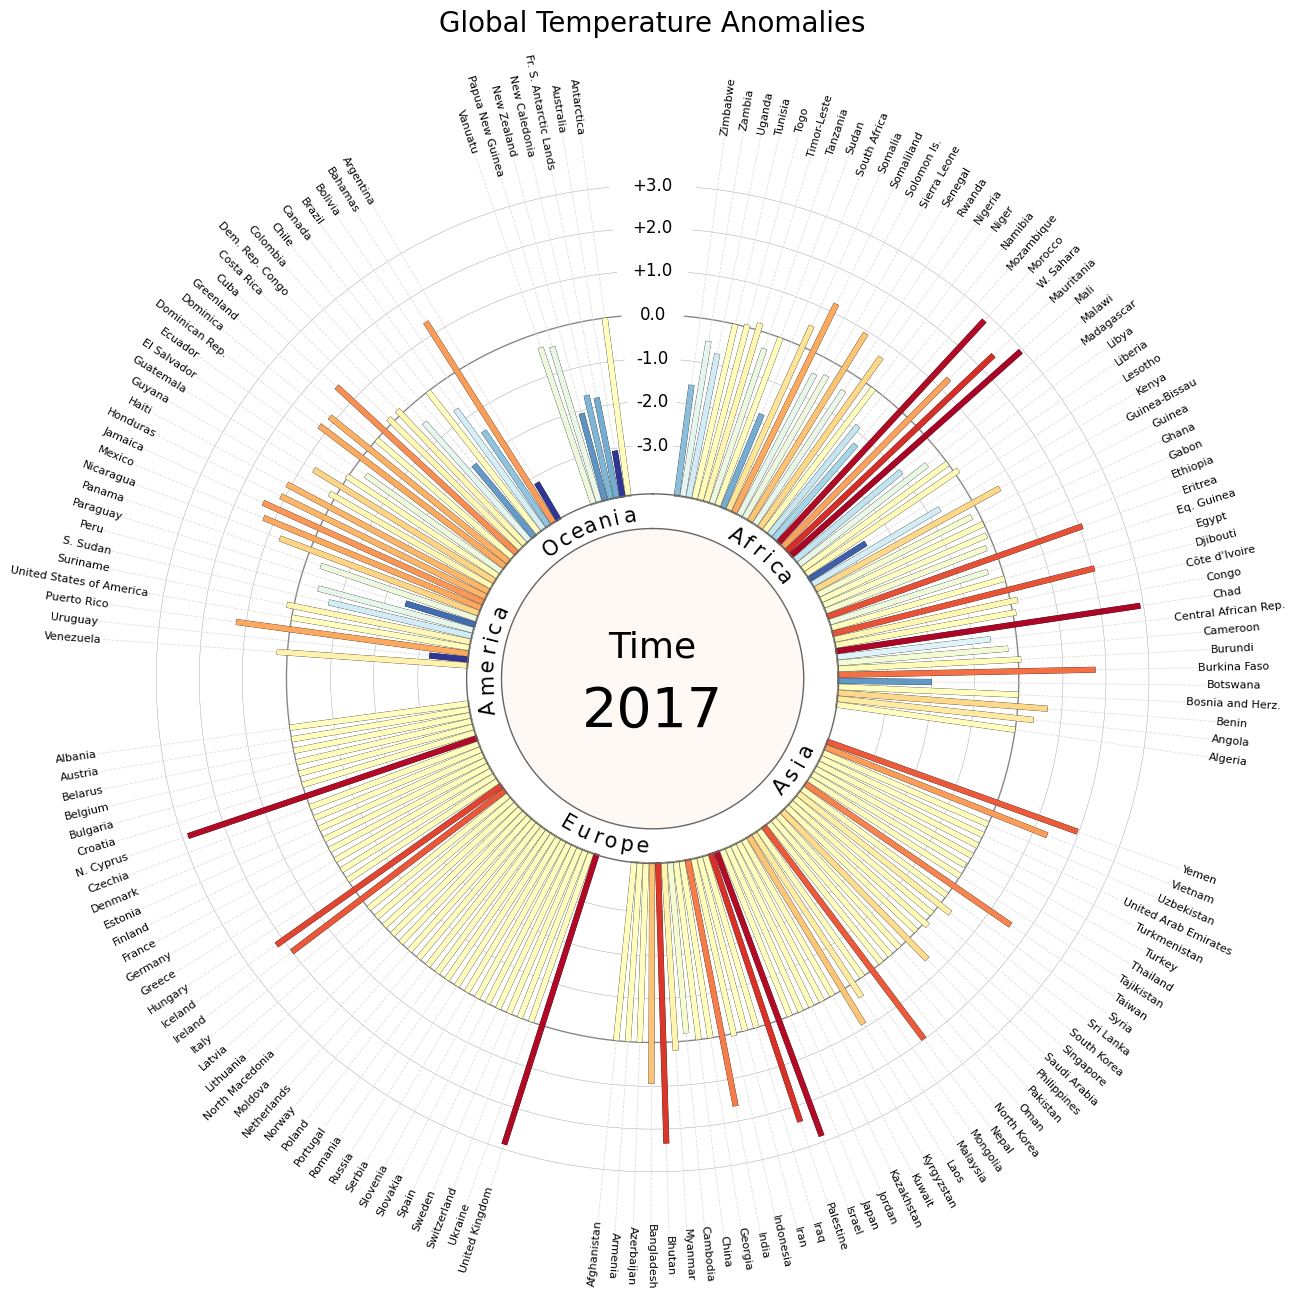

In [148]:
plot=plot_temperature_cirle(result,cmap='RdYlBu_r',vMin=-3,vMax=3,optnm='sam.png')
plot.show()

In [ ]:
output_directory = './plots'
lon = tas.lon
lat = tas.lat
for i in range(len(tas.time)):
    
    dat = tas[i]
    time = np.datetime_as_string(tas['time'][i],  unit='D')[-5:]
    tm = f'{time}'
    
    result = categorize_countries_by_continents(dat, lon, lat, climatology)
    
    output_filename = os.path.join(output_directory, f'tempcircle{time}.png')
    
    plot=plot_temperature_cirle(result,cmap='RdYlBu_r',vMin=-3,vMax=3,optnm=output_filename,year=tm)
    plot.close()
    print(f'plotted {tm}')
    
   

plotted 01-01
plotted 01-02
plotted 01-03
plotted 01-04
plotted 01-05
plotted 01-06
plotted 01-07
plotted 01-08
plotted 01-09
plotted 01-10
plotted 01-11
plotted 01-12
plotted 01-13
plotted 01-14
plotted 01-15
plotted 01-16
plotted 01-17
plotted 01-18
plotted 01-19
plotted 01-20
plotted 01-21
plotted 01-22
plotted 01-23
plotted 01-24
plotted 01-25
plotted 01-26
plotted 01-27
plotted 01-28
plotted 01-29
plotted 01-30
plotted 01-31
plotted 02-01
plotted 02-02
plotted 02-03
plotted 02-04
plotted 02-05
plotted 02-06
plotted 02-07
plotted 02-08
plotted 02-09
plotted 02-10
plotted 02-11
plotted 02-12
plotted 02-13
plotted 02-14
plotted 02-15
plotted 02-16
plotted 02-17
plotted 02-18
plotted 02-19
plotted 02-20
plotted 02-21
plotted 02-22
plotted 02-23
plotted 02-24
plotted 02-25
plotted 02-26
plotted 02-27
plotted 02-28
plotted 03-01
plotted 03-02
plotted 03-03
plotted 03-04
plotted 03-05
plotted 03-06
plotted 03-07
plotted 03-08
plotted 03-09
plotted 03-10
plotted 03-11
plotted 03-12


In [13]:
plot.close()

In [14]:
result

{'AMERICA': [['Venezuela', 0.2933803014457226],
  ['Uruguay', 0.0],
  ['Puerto Rico', 1.2067042291164398],
  ['United States of America', 0.0],
  ['S. Geo. and the Is.', -1.3954113237559795],
  ['Br. Indian Ocean Ter.', -0.05246247164905071],
  ['Saint Helena', -0.3341046394780278],
  ['Pitcairn Is.', -1.152685470879078],
  ['Anguilla', 0.9165233001112938],
  ['Falkland Is.', -1.006702147424221],
  ['Cayman Is.', 0.9562384337186813],
  ['Bermuda', 0.0],
  ['British Virgin Is.', 0.8399426937103271],
  ['Turks and Caicos Is.', 1.2812132015824318],
  ['Montserrat', 0.713600218296051],
  ['Trinidad and Tobago', 0.7073921617120504],
  ['Suriname', 0.14251794200390577],
  ['S. Sudan', -0.6916262675076723],
  ['Saint Lucia', 0.7394735235720873],
  ['St. Kitts and Nevis', 0.8674724027514458],
  ['Peru', -0.5419900640845299],
  ['Paraguay', -2.4841666221618652],
  ['Panama', 0.01717145787551999],
  ['Nicaragua', 0.7490724790841341],
  ['Aruba', 0.526197487488389],
  ['Curaçao', 0.55211004801094